# UK Traffic Accidents Severity Classification
4IZ565 – Programming for Data Science in Python

Spring Semester 2023/2024 Coursework

Authors: Terka Lukešová, Jan Štipl

## Dataset Description
The dataset contains statistics on traffic accidents in the UK, including many attributes, such as the route category and hazards, the vehicles involved, and some information about the drivers. Our goal will be to predict the target attribute Accident Severity, whose values are Slight/Serious/Fatal.

Dataset source: https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles

## Exploratory Data Analysis

### Initial settings

In [1]:
import random
import numpy as np
import sklearn
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sklearn.set_config(transform_output="pandas")

RANDOM_STATE = 42  # used throughout the notebook to make the results reproducible
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Load CSV tables and merge them 

In [2]:
# For speed during testing load only small percentage of the data
# p = 0.005  # 0.5% of the lines
# skip_rows = lambda i: i > 0 and random.random() > p
skip_rows = None

accidents_df = pd.read_csv("./data/Accident_Information.csv",
                           skiprows=skip_rows)
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 3169: invalid start byte
vehicle_df = pd.read_csv("./data/Vehicle_Information.csv", encoding="latin1")

C:\Users\admin\AppData\Local\Temp\ipykernel_10368\868122057.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_df = pd.read_csv("./data/Accident_Information.csv",


In [3]:
df = pd.merge(accidents_df, vehicle_df, on="Accident_Index", how="inner")
del vehicle_df
del accidents_df
df

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_x,InScotland,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,make,model,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
0,200501BS00002,B,450.000,C,0.000,Slight,NaN,2005-01-05,Wednesday,1.000,Auto traffic signal,Crossroads,51.520,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524170.000,181650.000,-0.212,E01002909,1,1,0.000,5.000,Metropolitan Police,Dry,Dual carriageway,NaN,30.000,17:36,Urban,Fine no high winds,2005,No,36 - 45,3.000,Data missing or out of range,NaN,8268.000,NaN,NaN,Journey as part of work,Leaving roundabout,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Slowing or stopping,1,Bus or coach (17 or more pass seats),No,Nearside,2005
1,200501BS00003,C,0.000,NaN,0.000,Slight,NaN,2005-01-06,Thursday,1.000,Data missing or out of range,Not at junction or within 20 metres,51.525,Darkness - lights lit,Kensington and Chelsea,Kensington and Chelsea,524520.000,182240.000,-0.206,E01002857,1,2,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,00:15,Urban,Fine no high winds,2005,No,26 - 35,5.000,Urban area,3.000,8300.000,Parked vehicle,NaN,Journey as part of work,Not at or within 20 metres of junction,DENNIS,NaN,Heavy oil,Male,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead right-hand bend,1,Bus or coach (17 or more pass seats),No,Nearside,2005
2,200501BS00004,A,3220.000,NaN,0.000,Slight,NaN,2005-01-07,Friday,1.000,Data missing or out of range,Not at junction or within 20 metres,51.482,Daylight,Kensington and Chelsea,Kensington and Chelsea,526900.000,177530.000,-0.174,E01002840,1,1,0.000,0.000,Metropolitan Police,Dry,Single carriageway,NaN,30.000,10:35,Urban,Fine no high winds,2005,No,46 - 55,4.000,Urban area,1.000,1769.000,NaN,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,NISSAN,ALMERA SE AUTO,Petrol,Female,NaN,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Car,No,Front,2005
3,200501BS00005,Unclassified,0.000,NaN,0.000,Slight,NaN,2005-01-10,Monday,1.000,Data missing or out of range,Not at junction or within 20 metres,51.496,Darkness - lighting unknown,Kensington and Chelsea,Kensington and Chelsea,528060.000,179040.000,-0.157,E01002863,1,1,0.000,0.000,Metropolitan Police,Wet or damp,Single carriageway,NaN,30.000,21:13,Urban,Fine no high winds,2005,No,46 - 55,10.000,Data missing or out of range,NaN,85.000,Kerb,NaN,Other/Not known (2005-10),Not at or within 20 metres of junction,HONDA,NaN,Petrol,Male,Skidded,No tow/articulation,Did not leave carriageway,0.000,Going ahead other,1,Motorcycle 125cc and under,No,Front,2005
4,200501BS00006,Unclassified,0.000,NaN,0.000,Slight,NaN,2005-01-11,Tuesday,1.000,Data missing or out of range,Not at junction or within 20 metres,51.516,Daylight,Kensington and Chelsea,Kensington and Chelsea,524770.000,181160.000,-0.203,E01002832,1,2,0.000,0.000,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.000,12:40,Urban,Raining no high winds,2005,No,46 - 55,1.000,Urban area,4.000,2976.000,NaN,NaN,Other/Not known

In [4]:
df.dtypes

Accident_Index                                  object
1st_Road_Class                                  object
1st_Road_Number                                float64
2nd_Road_Class                                  object
2nd_Road_Number                                float64
Accident_Severity                               object
Carriageway_Hazards                             object
Date                                            object
Day_of_Week                                     object
Did_Police_Officer_Attend_Scene_of_Accident    float64
Junction_Control                                object
Junction_Detail                                 object
Latitude                                       float64
Light_Conditions                                object
Local_Authority_(District)                      object
Local_Authority_(Highway)                       object
Location_Easting_OSGR                          float64
Location_Northing_OSGR                         float64
Longitude 

In [5]:
df.select_dtypes(include=['object']).nunique()

Accident_Index                 1389724
1st_Road_Class                       6
2nd_Road_Class                       6
Accident_Severity                    3
Carriageway_Hazards                  6
Date                              4383
Day_of_Week                          7
Junction_Control                     6
Junction_Detail                     10
Light_Conditions                     6
Local_Authority_(District)         416
Local_Authority_(Highway)          207
LSOA_of_Accident_Location        35475
Police_Force                        51
Road_Surface_Conditions              6
Road_Type                            7
Special_Conditions_at_Site           8
Time                              1439
Urban_or_Rural_Area                  3
Weather_Conditions                  10
InScotland                           2
Age_Band_of_Driver                  12
Driver_Home_Area_Type                4
Hit_Object_in_Carriageway           12
Hit_Object_off_Carriageway          12
Journey_Purpose_of_Driver

### Problems
* Unclassified and NaN in the same columns -> we have to merge
* Categorical values and not one-hot encoded

## Data preprocessing

### Stratify to have all target variable classes equally represented

In [6]:
target_variable = 'Accident_Severity'
target_classes = df[target_variable].value_counts()
target_classes

Accident_Severity
Slight     1765650
Serious     265426
Fatal        27332
Name: count, dtype: int64

In [7]:
p = 0.05  # 5% of the lines
samples_per_class = int(target_classes.min() * p)

# Randomly select subset for each class
indices = []
for class_label in target_classes.index:
    subset_indices = np.random.choice(df[df[target_variable] == class_label].index,
                                      samples_per_class,
                                      replace=False)
    indices.extend(subset_indices)

stratified_df = df.iloc[indices]
del indices

stratified_df[target_variable].value_counts()

Accident_Severity
Slight     1366
Serious    1366
Fatal      1366
Name: count, dtype: int64

### Separate the target class from attributes

In [8]:
# X, y = df.loc[:, df.columns != target_variable], df[target_variable]

X, y = stratified_df.loc[:, stratified_df.columns != target_variable], stratified_df[target_variable]
del df
del stratified_df

### Consolidate string values Unknown/Unclassified to NaN

In [9]:
X.replace(
    [
        "Not known",
        "Data missing or out of range",
        "Unclassified"
    ],
    np.nan, inplace=True)
X.fillna(np.nan, inplace=True)

### Train-test split
Our train-test ratio is 80:20. We make use of stratification because the target class is imbalanced.

In [10]:
from sklearn.model_selection import train_test_split

# stratifying preserves the proportion of how data is distributed in the target 
# same proportion of distribution in the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)
del X
del y

### Drop columns with too many missing values
The columns are identified on the train set, the drop is then applied to the test set too

In [11]:
# Get percentage of NaN values for each column
na_percentage = X_train.isna().mean() * 100
na_percentage.sort_values(ascending=False, inplace=True)
na_percentage

Carriageway_Hazards                           98.261
Special_Conditions_at_Site                    97.834
Hit_Object_in_Carriageway                     94.936
Hit_Object_off_Carriageway                    85.570
2nd_Road_Class                                84.960
Skidding_and_Overturning                      81.483
Junction_Control                              45.241
Journey_Purpose_of_Driver                     41.001
Driver_IMD_Decile                             32.337
1st_Road_Class                                21.721
model                                         18.151
Age_of_Vehicle                                15.894
Driver_Home_Area_Type                         12.874
Engine_Capacity_.CC.                          12.142
Propulsion_Code                               11.104
LSOA_of_Accident_Location                      7.840
Age_Band_of_Driver                             5.796
make                                           5.247
Sex_of_Driver                                 

In [12]:
to_drop = na_percentage[na_percentage > 40]
to_drop

Carriageway_Hazards          98.261
Special_Conditions_at_Site   97.834
Hit_Object_in_Carriageway    94.936
Hit_Object_off_Carriageway   85.570
2nd_Road_Class               84.960
Skidding_and_Overturning     81.483
Junction_Control             45.241
Journey_Purpose_of_Driver    41.001
dtype: float64

In [13]:
X_train.drop(columns=to_drop.index, inplace=True)
X_test.drop(columns=to_drop.index, inplace=True)

### Transformers

In [14]:
# Extract month from date
month_extractor = lambda x: pd.to_datetime(x['Date'], format='%Y-%m-%d').dt.month
X_train['month'] = month_extractor(X_train)
X_test['month'] = month_extractor(X_test)

# Extract hour from time
hour_extractor = lambda x: pd.to_datetime(x['Time'], format='%H:%M').dt.hour
X_train['hour'] = month_extractor(X_train)
X_test['hour'] = month_extractor(X_test)

In [15]:
numerical_variables = [
    # 'Number_of_Casualties', # Leaks info about accident severity
    # 'Number_of_Vehicles', # Leaks info about accident severity
    'Speed_limit',
    'Age_of_Vehicle',
    'Engine_Capacity_.CC.',
]

nominal_variables = [
    'Day_of_Week',
    'month',
    'hour',
    # 'Carriageway_Hazards',  Too many missing values
    'Junction_Detail',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities',
    'Road_Type',
    # 'Special_Conditions_at_Site', Too many missing values
    'Urban_or_Rural_Area',
    'Weather_Conditions',
    'Driver_Home_Area_Type',
    # 'Hit_Object_in_Carriageway', Too many missing values
    # 'Hit_Object_off_Carriageway', Too many missing values
    'Junction_Location',
    'make',
    'Propulsion_Code',
    'Sex_of_Driver',
    # 'Skidding_and_Overturning', Too many missing values
    'Towing_and_Articulation',
    'Vehicle_Leaving_Carriageway',
    'Vehicle_Location.Restricted_Lane',
    'Vehicle_Manoeuvre',
    'Vehicle_Type',
    'Was_Vehicle_Left_Hand_Drive',
    'X1st_Point_of_Impact',
]

# Order of the values can be determined lexicographically
ordinal_variables_auto = [
    'Age_Band_of_Driver',
    'Driver_IMD_Decile',
]

In [16]:
# Correct order must be set manually
ordinal_variables_manual = [
    '1st_Road_Class',
    # 'Junction_Control',
    'Light_Conditions',
    'Road_Surface_Conditions',
]

road_class_categories = ['Motorway', 'A(M)', 'A', 'B', 'C']

junction_control_categories = [
    'Not at junction or within 20 metres',
    'Authorised person',
    'Auto traffic signal',
    'Stop sign',
    'Give way or uncontrolled',
]

light_conditions_categories = [
    'Daylight',
    'Darkness - lights lit',
    'Darkness - lighting unknown',
    'Darkness - lights unlit',
    'Darkness - no lighting',
]

road_surface_conditions_categories = [
    'Dry',
    'Wet or damp',
    'Snow',
    'Frost or ice',
    'Flood over 3cm. deep',
]

manual_categories = [
    road_class_categories,
    # junction_control_categories,
    light_conditions_categories,
    road_surface_conditions_categories,
]

In [17]:
X_train.filter(nominal_variables + ordinal_variables_auto + ordinal_variables_manual).nunique()

Day_of_Week                                  7
month                                       12
hour                                        12
Junction_Detail                              9
Pedestrian_Crossing-Human_Control            3
Pedestrian_Crossing-Physical_Facilities      6
Road_Type                                    6
Urban_or_Rural_Area                          2
Weather_Conditions                           9
Driver_Home_Area_Type                        3
Junction_Location                            9
make                                       128
Propulsion_Code                              7
Sex_of_Driver                                2
Towing_and_Articulation                      6
Vehicle_Leaving_Carriageway                  9
Vehicle_Location.Restricted_Lane             8
Vehicle_Manoeuvre                           18
Vehicle_Type                                17
Was_Vehicle_Left_Hand_Drive                  2
X1st_Point_of_Impact                         5
Age_Band_of_D

In [18]:
from sklearn.compose import ColumnTransformer  # applies transformers to columns
from sklearn.pipeline import Pipeline  # assemble several steps
from sklearn.impute import SimpleImputer  # replace missing values using a descriptive statistic (e.g. mean, median,...)
from sklearn.preprocessing import OrdinalEncoder  # encode categorical features as an integer array
from sklearn.preprocessing import OneHotEncoder  # encode categorical features as a one-hot numeric array
from sklearn.preprocessing import \
    StandardScaler  # standardize features by removing the mean and scaling to unit variance

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)),
])

ord_pipe_auto = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder()),
])

ord_pipe_manual = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=manual_categories)),
])

transformers_list = [
    ('numerical', num_pipe, numerical_variables),
    ('nominal', cat_pipe, nominal_variables),
    ('ordinal_auto', ord_pipe_auto, ordinal_variables_auto),
    ('ordinal_manual', ord_pipe_manual, ordinal_variables_manual),
]

column_transformer = ColumnTransformer(transformers_list,
                                       remainder='drop',
                                       # If True, ColumnTransformer.get_feature_names_out will prefix all feature names with the name of the transformer that generated that feature.
                                       verbose_feature_names_out=False,
                                       verbose=False)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

del X_train
del X_test

C:\Users\admin\coding\.venv_general\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_encoder.classes_

array(['Fatal', 'Serious', 'Slight'], dtype=object)

## Modeling

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')
feature_selection = RFE(estimator=decision_tree, n_features_to_select=50, step=1)

### Logistic Regression

In [21]:
param_grid_regression = {
    'clf__C': (0.01, 0.1, 1, 10, 100, 1000),
    'clf__solver': ('lbfgs', 'sag', 'saga'),
}

classification_pipeline_regression = Pipeline([
    ('select', feature_selection),
    ('clf', LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', class_weight='balanced',
                               random_state=RANDOM_STATE))
])

search_acc_regression = GridSearchCV(estimator=classification_pipeline_regression, param_grid=param_grid_regression,
                                     cv=10, scoring='accuracy', n_jobs=-1, verbose=2)

search_acc_regression.fit(X_train_transformed, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select',
                                        RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                             random_state=42),
                                            n_features_to_select=50)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': (0.01, 0.1, 1, 10, 100, 1000),
                         'clf__solver': ('lbfgs', 'sag', 'saga')},
             scoring='accuracy', verbose=2)

In [22]:
search_acc_regression.best_estimator_

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                      random_state=42),
                     n_features_to_select=50)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

### Random Forest

In [23]:
param_grid_forest = {
    'clf__criterion': ('gini', 'entropy'),
    'clf__max_depth': (1, 4, 7, 10),
    'clf__min_samples_leaf': (1, 4, 7, 10),
}

classification_pipeline_forest = Pipeline([
    ('select', feature_selection),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

search_acc_forest = GridSearchCV(estimator=classification_pipeline_forest, param_grid=param_grid_forest, cv=10,
                                 scoring='accuracy', n_jobs=-1, verbose=2)

search_acc_forest.fit(X_train_transformed, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('select',
                                        RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                             random_state=42),
                                            n_features_to_select=50)),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ('gini', 'entropy'),
                         'clf__max_depth': (1, 4, 7, 10),
                         'clf__min_samples_leaf': (1, 4, 7, 10)},
             scoring='accuracy', verbose=2)

In [24]:
search_acc_forest.best_estimator_

Pipeline(steps=[('select',
                 RFE(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                      random_state=42),
                     n_features_to_select=50)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=4, random_state=42))])

## Results and Evaluation

### Logistic Regression

In [25]:
search_acc_regression.best_score_

0.5189294771388082

In [26]:
search_acc_regression.score(X_test_transformed, y_test)

0.5158536585365854

Ellipsis

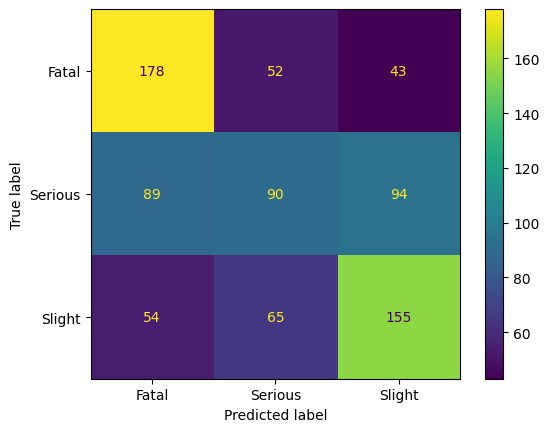

In [27]:
from sklearn import metrics

y_pred_regression = search_acc_regression.predict(X_test_transformed)
cnf_matrix_regression = metrics.confusion_matrix(y_test, y_pred_regression,
                                                 labels=search_acc_regression.classes_)
display = metrics.ConfusionMatrixDisplay(cnf_matrix_regression,
                                         display_labels=label_encoder.classes_)
display.plot()
...

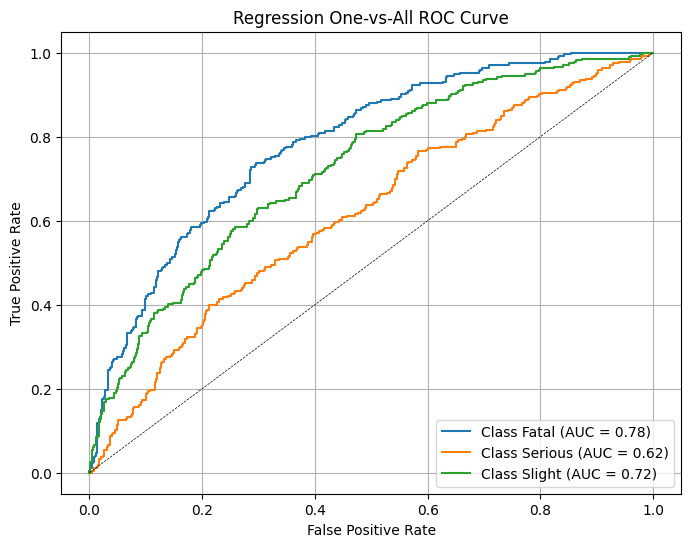

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def show_ova_roc(estimator, X_test, y_test, classes: list, name: str):
    """
    Computes "One-vs-All" (OvA) ROC curve
    
    ROC curve is constructed for each class separately by
    treating that class as the positive class and the rest as the negative class. 
    This results in multiple ROC curves, one for each class.
    :param estimator: 
    :param X_test: 
    :param y_test: 
    :param classes: 
    :param name: 
    :return: 
    """
    
    # Compute class probabilities for the test set
    y_proba = estimator.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(estimator.classes_)):
        fpr[i], tpr[i], _ = roc_curve((y_test == estimator.classes_[i]).astype(int), y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(estimator.classes_)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)  # Plot the diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} One-vs-All ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


show_ova_roc(search_acc_regression, X_test_transformed, y_test, label_encoder.classes_, "Regression")

### Random Forest

In [29]:
search_acc_forest.best_score_

0.5216677854851943

In [30]:
search_acc_forest.score(X_test_transformed, y_test)

0.5207317073170732

Ellipsis

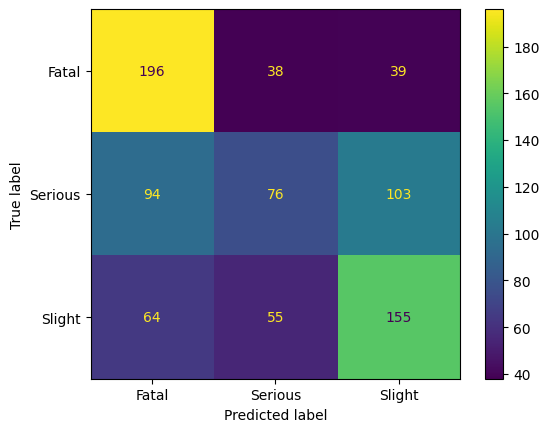

In [31]:
y_pred_forest = search_acc_forest.predict(X_test_transformed)
cnf_matrix_regression = metrics.confusion_matrix(y_test, y_pred_forest,
                                                 labels=search_acc_forest.classes_)
display = metrics.ConfusionMatrixDisplay(cnf_matrix_regression,
                                         display_labels=label_encoder.classes_)
display.plot()
...

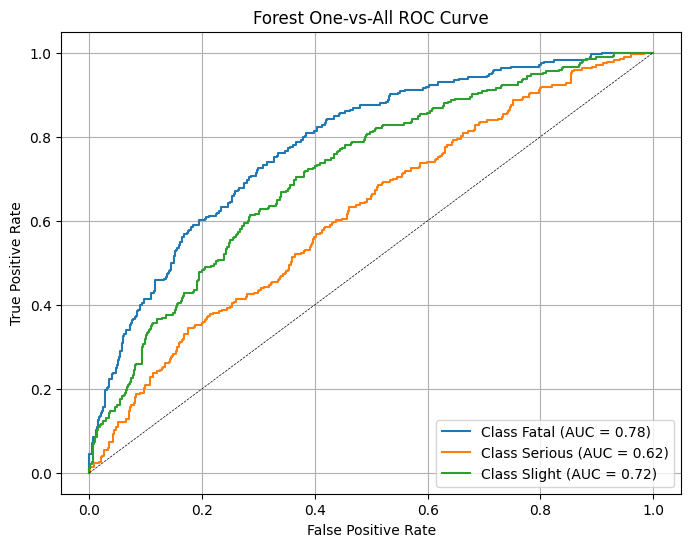

In [32]:
show_ova_roc(search_acc_forest, X_test_transformed, y_test, label_encoder.classes_, "Forest")

### Conclusion
In this course work we worked with UK Traffic Accidents data.
Our aim was to classify incident severity.

The source dataset is very large. In order to keep computation time on reasonable levels we randomly loaded 0.5% of the dataset.
We split the data to training and testing dataset in proportion 80:20.

We preprocessed the data by:
* merging dataset with accident information and dataset witch vehicle information
* removing variations of expressing missing values in the dataset 
* removing columns where more than 40% values were missing
* creating new column with extracted hour in day from time of the accident
* creating new column with extracted day in year from date of the accident
* using pipeline to handle missing values, encode and scale variables 

Then we built modeling pipeline for Logistic Regression and RandomForest.
The the pipeline consists of:
* Feature selection with Recursive Feature Elimination based on decision tree
* Hyper-parameter tuning and cross-validation using GridSearchCV   
* Training the model

We evaluated the models on their accuracy score and visualised trained model properties using:
*  Confusion Matrix
*  One-vs-All" (OvA) ROC curve

Overall RandomForest had great accuracy of ~0.86.
Logistic Regression model had poor accuracy of ~0.45.
We conclude that the poor performance was caused by the problem complexity and partly by not equal distribution of the target class in the training and test data.  
 